In [1]:
import pandas as pd
import numpy as np
import os
import random
import datetime
import tensorflow as tf
from tensorflow.keras.optimizers import Adam,SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,LSTM,TimeDistributed
from keras.layers import Convolution2D, MaxPooling2D,MaxPooling1D,Conv1D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import IPython
from scipy.io import wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import librosa
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display

In [2]:
Fs = 16000
sr = 16000
n_fft = 1024
n_mfcc = 64
hop_length = 512
win_length = 1024

In [3]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

In [4]:
def convert_y(y_pred,dim):
  Y = []
  if(dim==3):
    for i in range(len(y_pred)):
      index = np.argmax(y_pred[i])
      if (index==0):
        Y.append([1,0,0])
      elif(index==1):
        Y.append([0,1,0])
      else:
        Y.append([0,0,1])
  if(dim==2):
    for i in range(len(y_pred)):
      if(y_pred[i][0]>y_pred[i][1]):
        Y.append([1,0])
      else:
        Y.append([0,1])
  return np.array(Y)

In [5]:
def computeCM(y, y_hat,dim):
  confusion_matrix = np.zeros([dim, dim], dtype=int)
  for i in range(0,len(y)):
    i1 = np.argmax(y_hat[i])
    i2 = np.argmax(y[i])
    confusion_matrix[i2][i1] += 1
  return confusion_matrix

In [6]:
def noise_reduction(x):
    xt = x.T
    k1 = -1e7
    k2 = -1e7
    index1 = []
    index2 = []
    for i in range(len(xt)):
        id = np.argmax(xt[i])
        if(xt[i][id]>-20):
            id2 = np.argmin(xt[i])
            if((xt[i][id2]>k1)and(xt[i][id2]>-80)): k1 = xt[i][id2]
        else:
            if((xt[i][id]>k2)and(xt[i][id]>-80)): k2 = xt[i][id]
            index2.append(i)
            ind_max = np.argpartition(xt[i], -20)[-20:]
            k_max = np.sum(xt[i][ind_max])/20
            if k_max<-40:
                index1.append(i)
    
    if(k1<k2): k = k2
    else: k = k1

    avg = 0
    ni = 0
    
    for i in index1:
        z = xt[i][:]
        avg1 = np.sum(z)/len(z)
        avg = (avg1 + (avg*ni))/(ni+1)
        ni += 1
        z[z<0] = -80
        xt[i][:] = z
    if(len(index1)==0):
        for i in index2:
            z = xt[i][:]
            avg1 = np.sum(z)/len(z)
            avg = (avg1 + (avg*ni))/(ni+1)
            ni += 1
            z[z<0] = -80
            xt[i][:] = z
    return xt.T

In [7]:
def stft_to_mfcc(x,Fs,n_mfcc):
    x_mfcc = []
    xt = x.T
    for i in range(0,312,4):
        mfcc = librosa.feature.mfcc(S = xt[:][i:i+4].T, sr = Fs, n_mfcc = n_mfcc)
        if(len(mfcc[0])*(len(mfcc))==64*4):
            x_mfcc.append(mfcc)
        if(len(x_mfcc[0])==78):break
    return np.array(x_mfcc)

In [77]:
silence_pred = tf.keras.models.load_model("silence_pred.tf")

In [78]:
X=[]
Y=[]

In [79]:
silence_path = "Silence/Spectrogram/"
for file in os.listdir(silence_path):
    a = (np.load(silence_path+file))
    a = noise_reduction(a)
    a = stft_to_mfcc(a,Fs,n_mfcc)
    
    K = []
    for i in range(len(a)):
        k = a[i].flatten()
        if(len(k)!=256):
          continue
        K.append(k)
    K = np.array(K)
    
    for i in range(len(K)):
        X.append(np.array(K[i]))
        Y.append([0,0,1])

In [80]:
music_path = 'Music/Spectrogram/'
for file in os.listdir(music_path):
    a = (np.load(music_path+file))
    a = stft_to_mfcc(a,Fs,n_mfcc)
    K = []
    for i in range(len(a)):
        k = a[i].flatten()
        if(len(k)!=256):
          continue
        K.append(k)
    K = np.array(K)
    for i in range(len(K)):
        X.append(np.array(K[i]))
        Y.append([1,0,0])
#         if(y_pred[i]>=0.59): Y.append([0,0,1])
#         else :Y.append([1,0,0])

In [81]:
speech_path = "Speech/Spectrogram/"
j = 0
for file in os.listdir(speech_path):
    if(j==100):break
    a = (np.load(speech_path+file))
    a = stft_to_mfcc(a,Fs,n_mfcc)
    K = []
    for i in range(len(a)):
        k = a[i].flatten()
        if(len(k)!=256):
          continue
        K.append(k)
    K = np.array(K)
    y_pred = silence_pred.predict(K)
    for i in range(len(K)):
        X.append(np.array(K[i]))
#         Y.append([0,1,0])
        if(y_pred[i]>=0.59): Y.append([0,0,1])
        else :Y.append([0,1,0])
    j += 1

In [82]:
X = np.array(X)
y = np.array(Y)

In [83]:
print(X.shape)

(33290, 256)


In [84]:
print(y.shape)

(33290, 3)


In [85]:
np.sum(y,axis=0)

array([21590,  6296,  5404])

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [87]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

In [88]:
Linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=3)
])

In [89]:
Linear_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 256)              513       
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,284
Trainable params: 771
Non-trainable params: 513
_________________________________________________________________


In [90]:
Linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='mean_absolute_error')

In [91]:
history = Linear_model.fit(
    X_train,
    y_train,
    epochs=30,
    verbose=0,
    validation_data=(X_val,y_val))

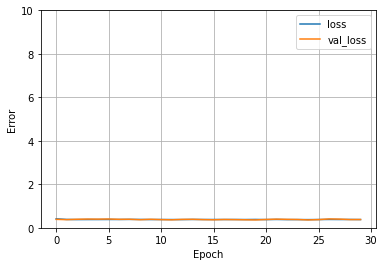

In [92]:
plot_loss(history)

In [93]:
results = Linear_model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

209/209 [==============================] - 0s 647us/step - loss: 0.3833
test loss, test acc: 0.3833075165748596


In [94]:
y_pred = Linear_model.predict(X_test)

In [95]:
y_pred = convert_y(y_pred,3)

In [96]:
CM = computeCM(y_test,y_pred,3)
CM

array([[3440,  515,  379],
       [ 551,  527,  141],
       [ 472,  122,  511]])

In [97]:
accuracy_score(y_test,y_pred)

0.6725743466506459

In [98]:
tf.keras.models.save_model(Linear_model,'Linear_model.tf')

INFO:tensorflow:Assets written to: Linear_model.tf\assets
